In [1]:
import pandas as pd
import plotly
# Read the CSV file
df = pd.read_excel('hbv_results.xlsx')  # Assuming tab-separated based on your image


In [2]:
df.head()

,Date,Qsim,Qobs,Precipitation,Temperature,AET,PET,Snow,Snowcover,SM,Recharge,SUZ,SLZ,Q0,Q1,Q2,Unnamed: 16,Unnamed: 17,calibration,SubCatchment_1
0,1981-01-15,0.104,0.103,0.1,21.9,0.24,0.24,0,0,348511.0,0.0,0.0,4.2,0.0,0.0,0.104,NaN,NaN,Water Balance [mm/year]:,NaN
1,1981-01-16,0.107,0.100,0.1,21.9,0.24,0.24,0,0,348510.8,0.0,0.0,4.1,0.0,0.0,0.107,NaN,NaN,Sum Qsim,289.465962
2,1981-01-17,0.110,0.099,0.0,21.9,0.24,0.24,0,0,348510.6,0.0,0.0,4.0,0.0,0.0,0.110,NaN,NaN,Sum Qobs,252.337962
3,1981-01-18,0.111,0.099,0.5,21.9,0.24,0.24,0,0,348510.7,0.1,0.0,4.0,0.0,0.0,0.111,NaN,NaN,Sum Precipitation,1148.833196
4,1981-01-19,0.111,0.096,0.5,21.9,0.24,0.24,0,0,348510.8,0.1,0.0,4.0,0.0,0.0,0.111,NaN,NaN,Sum AET,86.749800


In [ ]:
# Import the model
from hbv_model import HBVModel
import pandas as pd


# 1. Initialize the model
model = HBVModel()

# # 2. Load your data (either from file or DataFrame)
# # Read the data from pandas df
model.load_data(data=df,
               date_column='Date',
               precip_column='Precipitation',
               temp_column='Temperature',
               pet_column='PET',
               obs_q_column='Qobs')
            #   start_date='1982-01-15',          # start date you want
            #  end_date='2005-01-15'     )  # if you have observed discharge




Time step detected: D
Loaded data with 9117 time steps, from 1981-01-15 00:00:00 to 2005-12-31 00:00:00


In [11]:

custom_params= {
    'snow': {
        'TT': {'min': -2.0, 'max': 2.0, 'default': 0.0},
        'CFMAX': {'min': 1.0, 'max': 6.0, 'default': 4},
        'PCF': {'min': 0.5, 'max': 1.5, 'default': 0.3},
        'SFCF': {'min': 0.5, 'max': 1.5, 'default': 0.3},
        'CFR': {'min': 0.0, 'max': 0.2, 'default': 0.05},
        'CWH': {'min': 0.0, 'max': 0.2, 'default': 0.1}
    },
    'soil': {
        'FC': {'min': 50.0, 'max': 300.0, 'default': 450.0},
        'LP': {'min': 0.3, 'max': 1.0, 'default': 0.75},
        'BETA': {'min': 1.0, 'max': 5.0, 'default': 3.0}
    },
    'response': {
        'K0': {'min': 0.1, 'max': 0.9, 'default': 0.12},
        'K1': {'min': 0.05, 'max': 0.5, 'default': 0.01},
        'K2': {'min': 0.01, 'max': 0.1, 'default': 0.01},
        'UZL': {'min': 5.0, 'max': 50.0, 'default': 28.0},
        'PERC': {'min': 0.5, 'max': 3.0, 'default': 0.25}
    }
}


# 3. Set parameters (optional - uses defaults if not set)
# custom_params = {
#     'snow': {
#                 'TT': 0,      # Temperature threshold for snow/rain (°C)
#                 'CFMAX':4,   # Degree-day factor (mm/°C/day)
#                 'PCF': 0.3,    # precipitation correction factor (-)
#                 'SFCF': 0.3,    # Snowfall correction factor (-)
#                 'CFR': 0.05,    # Refreezing coefficient (-)
#                 'CWH': 0.1      # Water holding capacity of snow (-)
#             },
#             'soil': {
#                 'FC': 450,    # Field capacity (mm)
#                 'LP': 0.75,      # Limit for potential evaporation (-)
#                 'BETA': 3     # Shape coefficient (-)
#             },
#             'response': {
#                 'K0': 0.124,      # Quick flow recession coefficient (1/day)
#                 'K1': 0.011,      # Intermediate flow recession coefficient (1/day)
#                 'K2': 0.01,     # Baseflow recession coefficient (1/day)
#                 'UZL': 28,    # Upper zone threshold (mm)
#                 'PERC': 0.25     # Percolation rate (mm/day)
#             }
#         }
model.set_parameters(custom_params)

# #4. Set initial conditions (optional - uses defaults if not set)
# model.set_initial_conditions(
#     snowpack=0,  #initial snowpack (mm)
#     liquid_water=0,    # Initial liquid water in snow (mm)
#     soil_moisture= 420,  # Initial soil moisture (mm)
#     upper_storage=30,   # Initial upper zone storage (mm)
#     lower_storage=30  # Initial lower zone storage (mm)
# )

# 5. Run the model
results = model.run()

Starting model run for 9117 time steps...
Model run completed successfully!
Performance metrics calculated:
NSE: 0.828
KGE: 0.751
PBIAS: 2.3%
Correlation: 0.924


Figure saved to fig.png


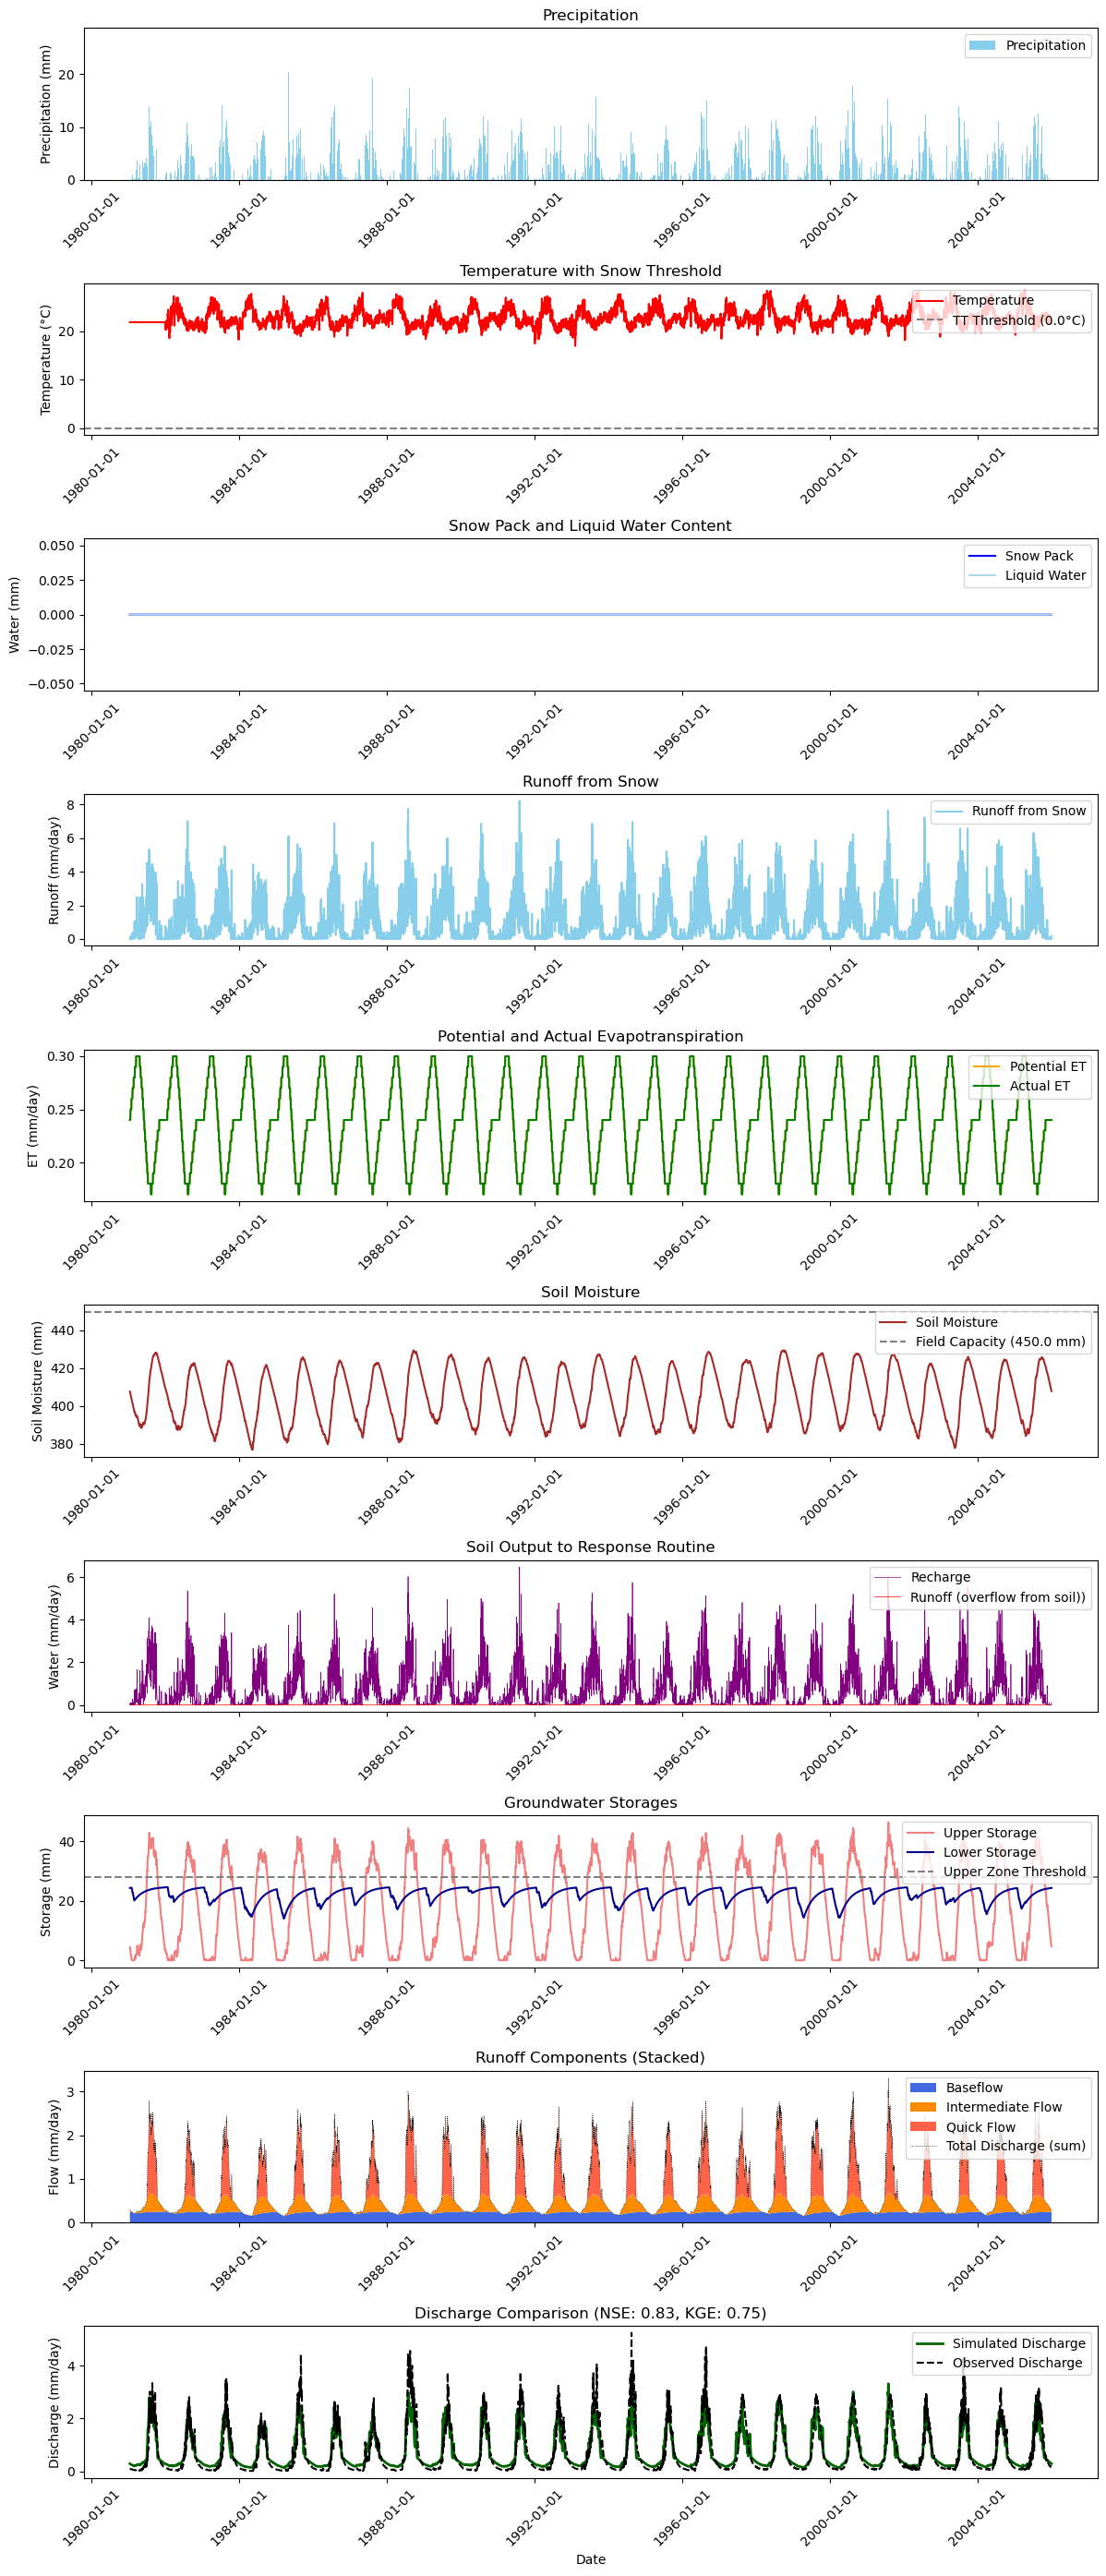

Results saved to hbv_simulation_results.csv


In [12]:
#6. Visualize results
model.plot_results(output_file='fig.png')

#7. Save results to CSV (optional)
model.save_results("hbv_simulation_results.csv")